# Notebook de segmentation - Adrian Rodriguez - Projet 3 parcours Ingénieur Machine Learning

---
# 0. Contexte


Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

---
# 1. Importation et exploration préliminaire

In [1]:
import pandas as pd

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly

from functions import *

pd.options.display.max_columns = None
plt.style.use("default")

In [2]:
# Pour vérifier le respect de la convention PEP8
# Installation conda non diponible. Utiliser pip
%load_ext pycodestyle_magic
%pycodestyle_on

In [3]:
sales_raw = pd.read_csv('src/sales.csv')

In [4]:
sales_raw.shape

(96946, 13)

In [5]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96946 entries, 0 to 96945
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96946 non-null  object 
 1   order_purchase_timestamp  96946 non-null  object 
 2   delivery_respect          96946 non-null  int64  
 3   period                    96946 non-null  object 
 4   customer_unique_id        96946 non-null  object 
 5   n_item                    96946 non-null  float64
 6   main_category_fr          96946 non-null  object 
 7   n_photos_class            96946 non-null  float64
 8   len_desc_class            96946 non-null  float64
 9   ratio_freight_amount      96946 non-null  float64
 10  prefered_payment          96946 non-null  object 
 11  total_paid                96946 non-null  float64
 12  review_score              96946 non-null  int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 9.6+ MB


In [6]:
sales_raw.columns

Index(['order_id', 'order_purchase_timestamp', 'delivery_respect', 'period',
       'customer_unique_id', 'n_item', 'main_category_fr', 'n_photos_class',
       'len_desc_class', 'ratio_freight_amount', 'prefered_payment',
       'total_paid', 'review_score'],
      dtype='object')

In [7]:
sales_raw.dtypes

order_id                     object
order_purchase_timestamp     object
delivery_respect              int64
period                       object
customer_unique_id           object
n_item                      float64
main_category_fr             object
n_photos_class              float64
len_desc_class              float64
ratio_freight_amount        float64
prefered_payment             object
total_paid                  float64
review_score                  int64
dtype: object

In [8]:
sales_raw['order_purchase_timestamp'] = \
    pd.to_datetime(sales_raw['order_purchase_timestamp'],
                   format="%Y-%m-%d %H:%M:%S")

In [9]:
sales_raw.head()

,order_id,order_purchase_timestamp,delivery_respect,period,customer_unique_id,n_item,main_category_fr,n_photos_class,len_desc_class,ratio_freight_amount,prefered_payment,total_paid,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2,2017-Q4,7c396fd4830fd04220f754e42b4e5bff,1.0,Electoménager,3.0,1.0,22.53,voucher,38.71,4
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2,2018-Q3,af07308b275d755c9edb36a90c618231,1.0,Mode Bagage,1.0,1.0,16.09,boleto,141.46,4
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2,2018-Q3,3a653a41f6f9fc3d2a113cf8398680e8,1.0,Auto Moto,1.0,1.0,10.73,credit_card,179.12,5
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2,2017-Q4,7c142cf63193a1473d2e66489a9ae977,1.0,Jardin Animalerie,2.0,2.0,37.67,credit_card,72.20,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2,2018-Q1,72632f0f9dd73dfee390c9b22eb56dd6,1.0,Librairie,3.0,1.0,30.47,credit_card,28.62,5


In [10]:
sales = sales_raw.copy()

In [39]:
customer_RFM_plot = customer_RFM.reset_index().copy()

## 4-1. Catégories des ventes

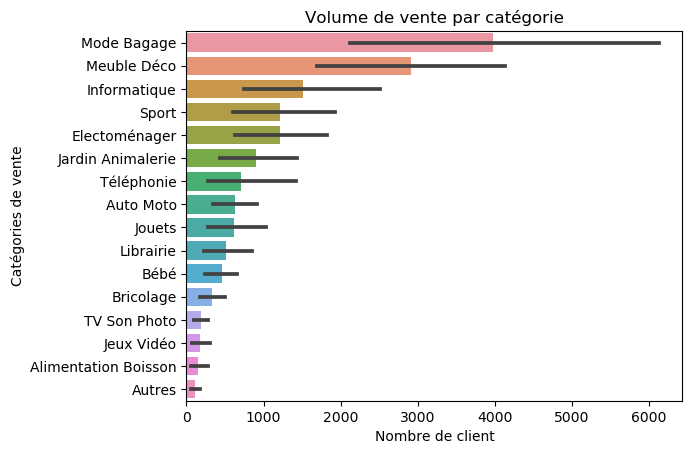

In [40]:
# Je classe les catégories par ordre d'importance
category = customer_RFM_plot.groupby('main_category_fr')['customer_unique_id']\
                            .count()
order = category.sort_values(ascending=False).index.to_list()

# Je groupe par produit et par cluster
group = ['main_category_fr', 'cluster_name']
customer_cat = customer_RFM_plot.groupby(group)['customer_unique_id']\
                                .count().reset_index()

plt.clf()
sns.barplot(y='main_category_fr',
            x='customer_unique_id',
            data=customer_cat,
            order=order,
            orient='h')
plt.title('Volume de vente par catégorie')
plt.xlabel('Nombre de client')
plt.ylabel('Catégories de vente')

plt.savefig('img/img_cat_customers.png',
            transparent=True,
            bbox_inches="tight")

Les ventes sont dominées par les catégories "Mode Bagages" et "Meuble Déco".

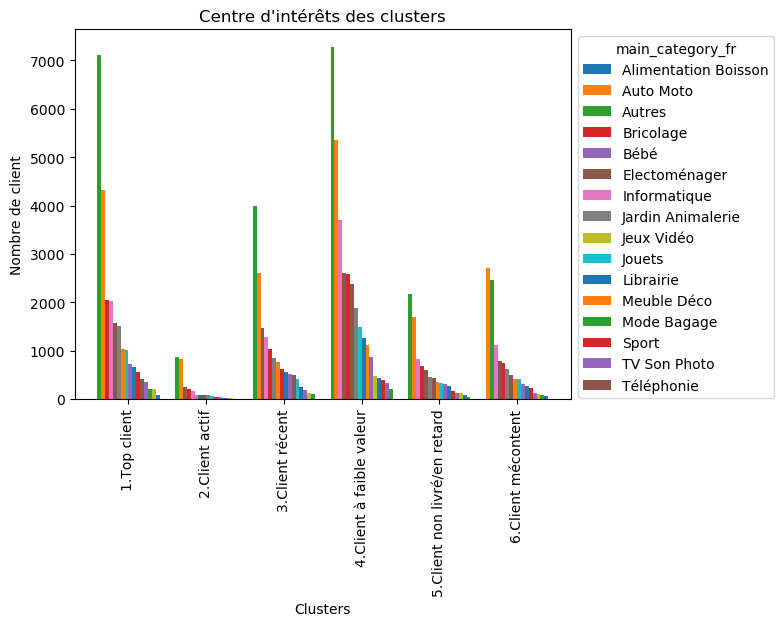

In [41]:
# Je groupe par produit et par cluster
group = ['main_category_fr', 'cluster_name']
customer_cat = customer_RFM_plot.groupby(group)['customer_unique_id']\
                                .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="main_category_fr",
                 data=customer_cat,
                 legend_anchor=(1, 1))

plt.title("Centre d'intérêts des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_cat_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

La catégorie "Mode Bagage" occupe une place prédominante dans les 3 premières catégories. La catégorie informatique occupe un place intéressante dans le cluster des clients récents. Peut-être une ouverture de marché ?

## 4-2. Informations relatives à la commande

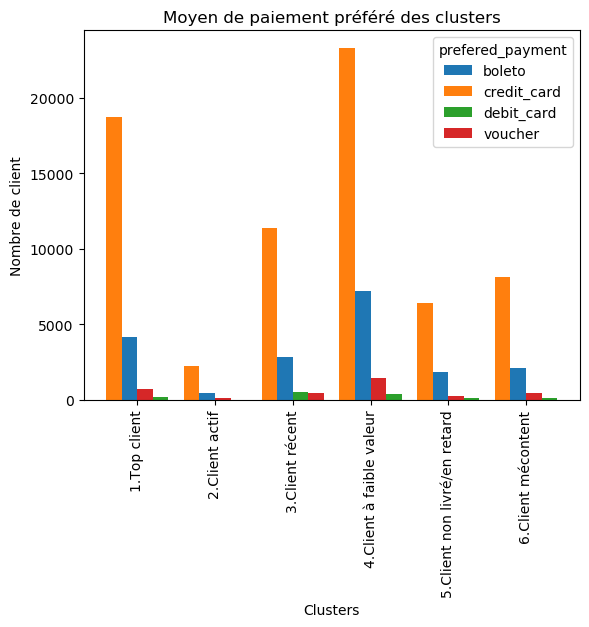

In [42]:
group = ['prefered_payment', 'cluster_name']
customer_payment = customer_RFM_plot.groupby(group)['customer_unique_id']\
                                    .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="prefered_payment",
                 data=customer_payment)

plt.title("Moyen de paiement préféré des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_payment_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

Il n'y a pas un cluster qui préfère un paiement plus qu'un autre

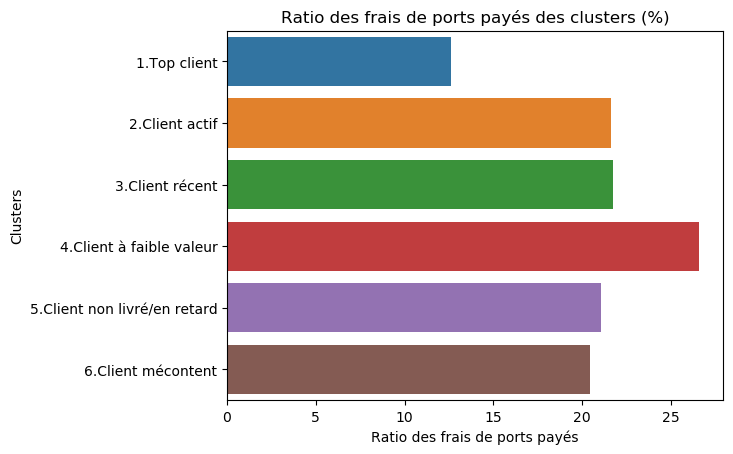

In [43]:
customer_freight = customer_RFM_plot\
                    .groupby('cluster_name')['ratio_freight_amount']\
                    .mean().reset_index()

sns.barplot(y='cluster_name',
            x='ratio_freight_amount',
            data=customer_freight,
            orient='h')

plt.title("Ratio des frais de ports payés des clusters (%)")
plt.xlabel('Ratio des frais de ports payés')
plt.ylabel('Clusters')
plt.savefig('img/img_freight_paid_cluster.png',
            transparent=True,
            bbox_inches="tight")

Le top client paye peu de frais de port alors que le client récent en paye beaucoup.

## 4-3. Informations relatives à la fiche produit

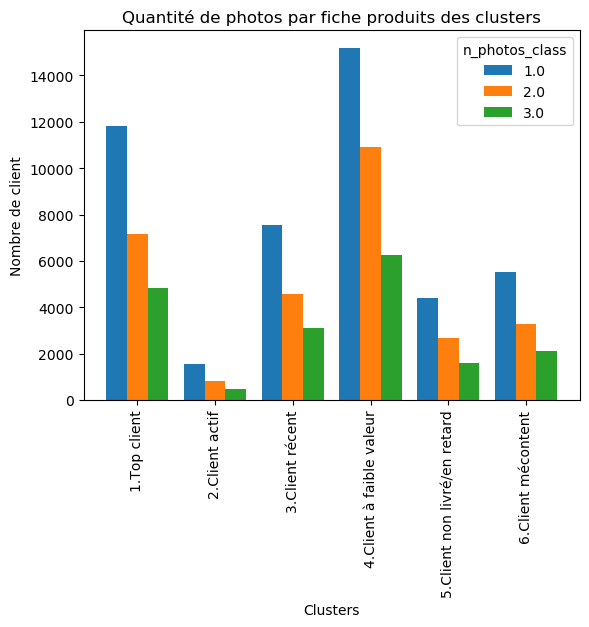

In [44]:
# Nombre de photos
group = ['n_photos_class', 'cluster_name']
customer_photos = customer_RFM_plot.groupby(group)['customer_unique_id']\
                                   .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="n_photos_class",
                 data=customer_photos)

plt.title("Quantité de photos par fiche produits des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_review_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

La quantité de photos présentes sur une fiche produit n'influence pas un cluster plus que l'autre

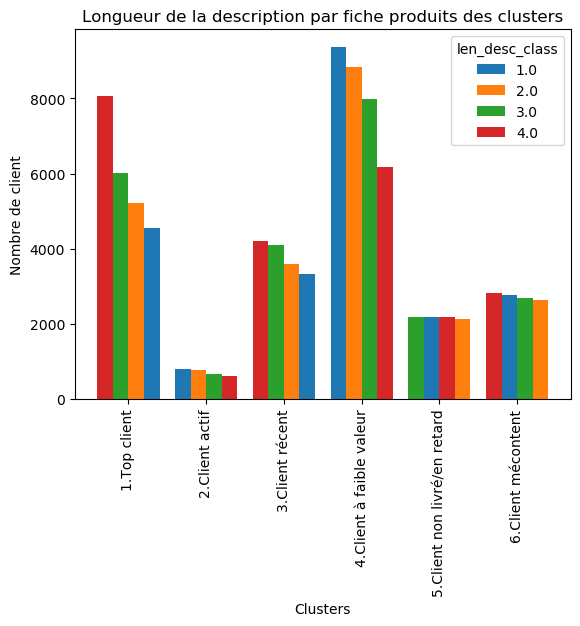

In [45]:
# Longueur de la description
group = ['len_desc_class', 'cluster_name']
customer_description = customer_RFM_plot.groupby(group)['customer_unique_id']\
                                        .count().reset_index()

fig, ax = plt.subplots()
sortedgroupedbar(ax,
                 x="cluster_name",
                 y="customer_unique_id",
                 groupby="len_desc_class",
                 data=customer_description)

plt.title("Longueur de la description par fiche produits des clusters")
plt.xlabel('Clusters')
plt.ylabel('Nombre de client')
plt.xticks(rotation=90)
plt.savefig('img/img_review_customers_cluster.png',
            transparent=True,
            bbox_inches="tight")

Le top client aime les descriptions bien remplies

## 4-4. Situation du score RFM dans la segmentation non supervisée.

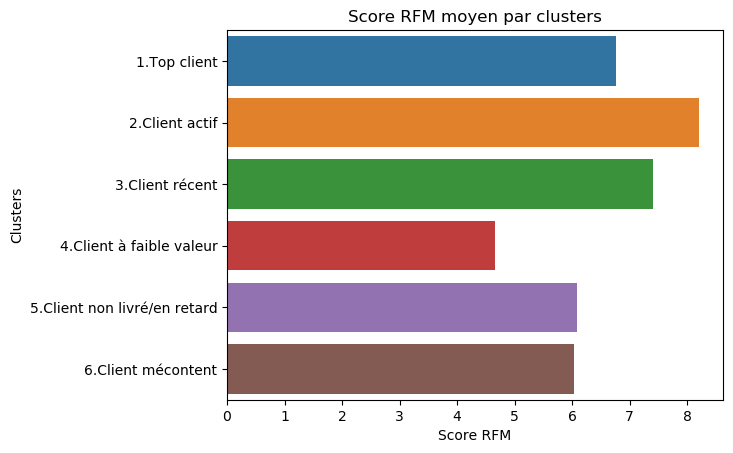

In [46]:
customer_RFM_Score = customer_RFM_plot\
                    .groupby('cluster_name')['RFM_Score']\
                    .mean().reset_index()

sns.barplot(y='cluster_name',
            x='RFM_Score',
            data=customer_RFM_Score,
            orient='h')

plt.title("Score RFM moyen par clusters")
plt.xlabel('Score RFM')
plt.ylabel('Clusters')

plt.savefig('img/img_RFM_score_cluster.png',
            transparent=True,
            bbox_inches="tight")

Le client actif sera mieux placé avec une segmentation RFM que le client récent.